# Generative Adversarial Networks (GANs)

## Very Simple One Layer GAN

In order to understand the basic concept of GANs, we build a pair of simple one-layer GANs which generate simple 2x2 black and white images.

Inspired by: [gans by Luis Serrano](https://github.com/luisguiserrano/gans)

In [1]:
import numpy as np
import mlplot

### Real Data

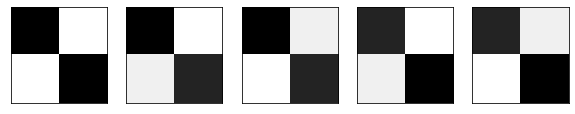

In [2]:
real_data = [np.array([1.0, 0.0, 0.0, 1.0]),
             np.array([0.9, 0.1, 0.2, 0.8]),
             np.array([0.9, 0.2, 0.1, 0.8]),
             np.array([0.8, 0.1, 0.2, 0.9]),
             np.array([0.8, 0.2, 0.1, 0.9])]
    
mlplot.plot_gan_samples(real_data);

### Exemplarey Noise Data

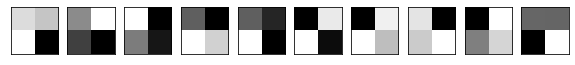

In [3]:
noise = [np.random.randn(2,2) for i in range(10)]
mlplot.plot_gan_samples(noise);

In [4]:
def sigmoid(x):
    return np.exp(x)/(1.0+np.exp(x))

### The Discriminator

The discriminator in a GAN is a **classifier** $D(x, w, c)$ which models the **probability**

$$D(x) = \sigma(x_1 w_1 + x_2 w_2 + x_3 w_3 + x_4 w_4 + c)$$

that the data $x$ came from the **real dataset** or not. 

This is a **binary classification problem**.

![GAN Discriminator](images/gan-discriminator.svg)

It’s weights $w$ are updated as to **maximize** the probability $D(x)$ that any **real** data input $x$ is classified as belonging to the **real** dataset, while **minimizing** the probability $D(x) = D(G(z))$ that any **fake** data $G(z)$ is classified as belonging to the **real** dataset.

For the **real data** $x_r$, we want the discriminator to **identify real** data, hence we want the **prediction to be $1$**, so we use the **loss function**

$$E = -ln(D(x_r))$$

with its derivative

$$
\begin{aligned}
   \frac{\partial E}{\partial w_i} &= \frac{\partial E}{\partial D} \frac{\partial D}{\partial w_i} \\[5pt]
                                   &= \frac{-1}{D(x)} \cdot D(x) \, \big(1 - D(x) \big) \, x_i \\[5pt]
                                   &= - \big(1 - D(x) \big) \, x_i
\end{aligned}
$$

For **fake data** $x_f = G(z)$, we want the discriminator to **identify** the data as being **not real** hence we want the **prediction to be $0$**, so we use the **loss function**

$$E = -ln(1 - D(x_f))$$

with its derivative

$$
\begin{aligned}
   \frac{\partial E}{\partial w_i} &= \frac{\partial E}{\partial D} \frac{\partial D}{\partial w_i} \\[5pt]
                                   &= \frac{1}{1 - D(x)} \cdot D(x) \, \big(1 - D(x) \big) \, x_i \\[5pt]
                                   &= D(x) \, x_i
\end{aligned}
$$

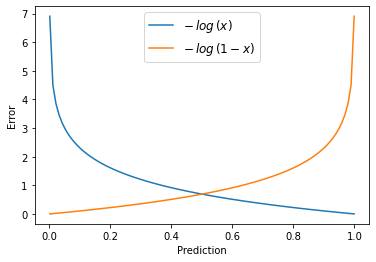

In [5]:
mlplot.plot_log();

In [6]:
class Discriminator:
    def __init__(self, lr):
        self.weights = np.array([np.random.normal() for i in range(4)])
        self.bias = np.random.normal()
        self.lr = lr
    
    def forward(self, x):
        return sigmoid(np.dot(x, self.weights) + self.bias)
    
    def error_real_data(self, data):
        prediction = self.forward(data)
        return - np.log(prediction)
    
    def backward_real_data(self, data):
        prediction = self.forward(data)
        weights = - (1 - prediction) * data
        bias = - (1 - prediction)
        self.weights -= self.lr * weights
        self.bias -= self.lr * bias

    def error_fake_data(self, data):
        prediction = self.forward(data)
        return - np.log(1 - prediction)
    
    def backward_fake_data(self, data):
        prediction = self.forward(data)
        weights = data * prediction
        bias = prediction
        self.weights -= self.lr * weights
        self.bias -= self.lr * bias 

### The Generator

The generator is trained to fool the discriminator by generating data as similar as possible to the real data. 

The generators weights $w$ are updated as to **maximize** the probability $D(G(z))$ that any **fake** data $G(z)$ is classified by the discriminator as belonging to the **real** dataset.

![GAN Generator](images/gan-generator.svg)

For the **fake data** $G(z) = (g_1, g_2, g_3, g_4)$ with $g_i = \sigma(v_i z + b_i)$, we want the **prediction of the discriminator to be $1$**, so we use the **loss function**

$$E = -ln(D(G(z)))$$

with

$$
\begin{aligned}
G(z) &= (g_1, g_2, g_3, g_4) \\
g_i &= \sigma(v_i z + b_i) \\
D(G(z)) &= \sigma \big(\sigma(v_1 z + c_1) \cdot w_1 + \sigma(v_2 z + c_2) \cdot w_2 + \sigma(v_3 z + c_3) \cdot w_3 + \sigma(v_4 z + c_4) \cdot w_4 + c\big)
\end{aligned}
$$

and its derivatives

$$
\begin{aligned}
   \frac{\partial E}{\partial v_i} &= \frac{\partial E}{\partial D} \frac{\partial D}{\partial G} \frac{\partial G}{\partial v_i} = - \big(1 - D(G(z)) \big) \cdot g_i (1 - g_i) \cdot z \\[5pt]
   \frac{\partial E}{\partial b_i} &= \frac{\partial E}{\partial D} \frac{\partial D}{\partial G} \frac{\partial G}{\partial b_i} = - \big(1 - D(G(z)) \big) \cdot g_i (1 - g_i) \\[5pt]
\end{aligned}
$$

In [7]:
class Generator:
    def __init__(self, lr):
        self.weights = np.array([np.random.normal() for i in range(4)])
        self.biases = np.array([np.random.normal() for i in range(4)])
        self.lr = lr

    def forward(self, z):
        return sigmoid(z * self.weights + self.biases)

    def error(self, z, discriminator):
        data = self.forward(z)
        prediction = discriminator.forward(data)
        return - np.log(prediction)

    def backward(self, z, discriminator):
        data = self.forward(z)
        prediction = discriminator.forward(data)
        factor = - (1 - prediction) * discriminator.weights * data * (1 - data)
        self.weights -= self.lr * factor * z
        self.biases -= self.lr * factor

### Training

In [8]:
from tqdm.notebook import trange

np.random.seed(3583795213)

# hyperparameters
learning_rate = 0.01
epochs = 1000

# the GAN
D = Discriminator(learning_rate)
G = Generator(learning_rate)

# error plots
discriminator_errors = []
generator_errors = []

# generated images plot
images = []

for epoch in trange(epochs):
    
    discriminator_error = []
    generator_error = []
    fake_datas = []
    
    for data in real_data:
        
        # update the discriminator weights from the real data
        D.backward_real_data(data)
    
        # use some noise for input
        z = np.random.rand()

        # calculate discriminator error for plot
        error = np.sum(D.error_real_data(data) + D.error_fake_data(z))
        discriminator_error.append(error)
        
        # calculate generator error for plot
        error = G.error(z, D)
        generator_error.append(error)
        
        # generate fake data
        fake_data = G.forward(z)
        fake_datas.append(fake_data)
        
        # update the discriminator weights from the fake data
        D.backward_fake_data(fake_data)
    
        # update the generator weights from the fake data
        G.backward(z, D)
        
    discriminator_errors.append(np.mean(discriminator_error))
    generator_errors.append(np.mean(generator_error))
    
    if epoch % 10 == 0:
        figs = mlplot.plot_generator(fake_datas, epoch=epoch)
        image = mlplot.fig2img(figs[0])
        images.append(image)

  0%|          | 0/1000 [00:00<?, ?it/s]

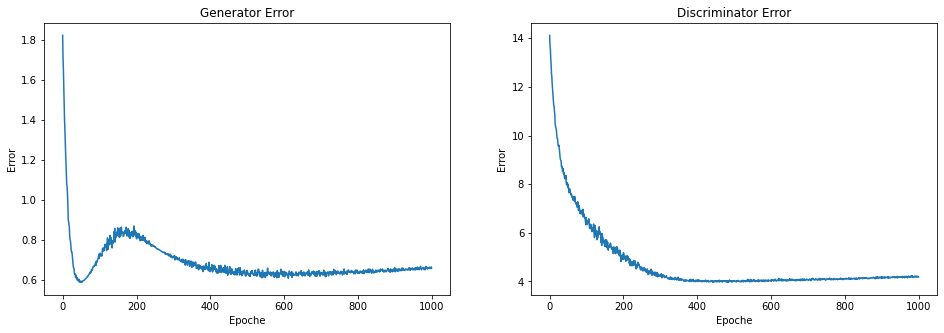

In [9]:
mlplot.plot_errors(generator_errors, discriminator_errors)

In [10]:
print(f'Weights: {G.weights}\nBiases:  {G.biases}')

Weights: [-0.20724256 -0.4842511  -1.20376619  1.03133993]
Biases:  [ 2.32128284 -3.10343015 -2.88381501  2.19506534]


In [13]:
from IPython.display import Image

images[0].save('images/simple_gan.gif', save_all=True, append_images=images[1:], optimize=False, duration=80, loop=0)
#Image(filename='images/simple_gan.gif')

![gan](images/simple_gan.gif)

### Generated Data

Noise Data:

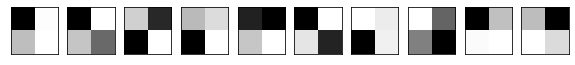

In [14]:
noise = [np.random.randn(2,2) for i in range(10)]
mlplot.plot_gan_samples(noise);

Generated Data of trained Generator

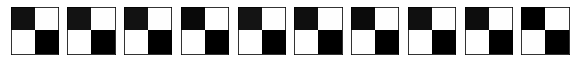

In [15]:
generated_data = [sigmoid(np.random.rand() * G.weights + G.biases) for i in range(10)]
mlplot.plot_gan_samples(generated_data);